In [59]:
from sklearn.datasets._samples_generator import make_blobs
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import random
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score

In [2]:
def generateRandomBlob(i):
  random.seed(i)
  n_cluster = random.randint(50, 200)
  n_samples = random.randint(4000, 8000)
  cluster_std = random.uniform(0.3, 0.8)
  return make_blobs(n_samples=n_samples, centers=n_cluster, cluster_std=cluster_std, random_state=42)

In [3]:
def showThreshold(threshold, link_matrix):
  plt.figure(figsize=(12,6))
  dendrogram(link_matrix)
  plt.xticks(fontsize=10, rotation=90)
  plt.axhline(y=threshold, color='red', linestyle='--', label=f'Soglia = {threshold}')
  plt.tight_layout()
  plt.show()

In [4]:
def findThreshold(link_matrix, verbose=True):
  old_nr = [-1,-1]
  for i in range(1,50):
    clusters = fcluster(link_matrix, t=i, criterion='distance')
    n_cluster = len(set(clusters))
    
    if(n_cluster == old_nr[0] and n_cluster == old_nr[1]):
      if(verbose):
        showThreshold(i, link_matrix)
      return [i, n_cluster]
    
    old_nr = [old_nr[1], n_cluster]
  return [-1, 0]

In [5]:
def adaptiveThresholdParams(link_matrix, X):
    from scipy.spatial.distance import pdist
    
    n_samples = X.shape[0]
    avg_dist = np.mean(pdist(X))
    merge_gaps = link_matrix[-10:, 2]
    gap_ratio = merge_gaps[-1] / (merge_gaps[-2] + 1e-8)

    # Adatta i parametri
    sample_frac = 0.1 if n_samples > 10000 else 0.3
    step = 10 if n_samples > 10000 else 2
    max_t = 80 if gap_ratio > 1.5 else 40

    return [step, max_t, sample_frac]

In [ ]:
#max_t=50, step=5, sample_frac=0.2
def findBestThresholdWithClustersFast(link_matrix, X, max_t="auto", step="auto", sample_frac="auto", random_state=42, verbose=False):
   if(max_t == 'auto' or step=='auto' or sample_frac == 'auto'):
    step, max_t, sample_frac = adaptiveThresholdParams(link_matrix, X)
    if (verbose):
        print(f'max_t: {max_t}, step: {step}, sample_frac: {sample_frac}')
    rng = np.random.default_rng(random_state)
    n_samples = int(len(X) * sample_frac)
    idx_sample = rng.choice(len(X), n_samples, replace=False)
    X_sample = X[idx_sample]
    
    best_score = -1
    best_t = -1
    best_n_cluster = 0
    
    for t in range(1, max_t, step):
        clusters = fcluster(link_matrix, t=t, criterion='distance')
        clusters_sample = clusters[idx_sample]
        n_clusters = len(set(clusters_sample))
        if n_clusters < 2:
            continue
        
        score = silhouette_score(X_sample, clusters_sample)
        if score > best_score:
            best_score = score
            best_t = t
            best_n_cluster = n_clusters
    
    return best_t, best_n_cluster, best_score

In [7]:
def estimate_centroids(data, linked, threshold):
  if isinstance(data, np.ndarray):
      data = pd.DataFrame(data, columns=[f"x{i+1}" for i in range(data.shape[1])])
  
  cluster_labels = fcluster(linked, t=threshold, criterion='distance')
  data['cluster'] = cluster_labels

  centroidi = data.groupby('cluster').mean(numeric_only=True)

  return centroidi

In [8]:
def scores (true_labels, predicted_labels):
  hom = homogeneity_score(true_labels, predicted_labels)
  comp = completeness_score(true_labels, predicted_labels)
  v = v_measure_score(true_labels, predicted_labels)
  return [hom, comp, v]

In [9]:
X, true_lables = generateRandomBlob(12)

creo la matrice di linkage

In [10]:
link_matrix = linkage(X, method="ward")

In [11]:
dfLinkMatrix = pd.DataFrame(link_matrix)

dfLinkMatrix

,0,1,2,3
0,263.0,4144.0,0.002279,2.0
1,370.0,4388.0,0.004539,2.0
2,128.0,394.0,0.005605,2.0
3,355.0,4526.0,0.007176,2.0
4,1658.0,2854.0,0.008173,2.0
...,...,...,...,...
5095,10189.0,10193.0,154.557087,1276.0
5096,10190.0,10192.0,167.476259,1547.0
5097,10194.0,10195.0,325.586201,2278.0
5098,10196.0,10197.0,416.513827,2823.0


In [12]:
pd.DataFrame(dfLinkMatrix.groupby(dfLinkMatrix[3])[3].count()).to_csv('link_matrix.csv', index=False)

trovo il threshold

In [35]:
# threshold, value = findThreshold(link_matrix )
threshold, value, best_score  = findBestThresholdWithClustersFast(link_matrix=link_matrix, X=X, verbose=True)

max_t: 40, step: 2, sample_frac: 0.3


In [37]:
best_score

np.float64(0.4230392377652305)

In [38]:
threshold, value

(29, 26)

In [52]:
dfy = pd.DataFrame(y)
dfy[0].unique().shape

(26,)

l'algoritmo suddivide lo spazio in 29 clusters quando in origine sono stati creati 26

stimo i centroidi

In [53]:
centroids = estimate_centroids(X, link_matrix, threshold=threshold)


visualizzo il risultato

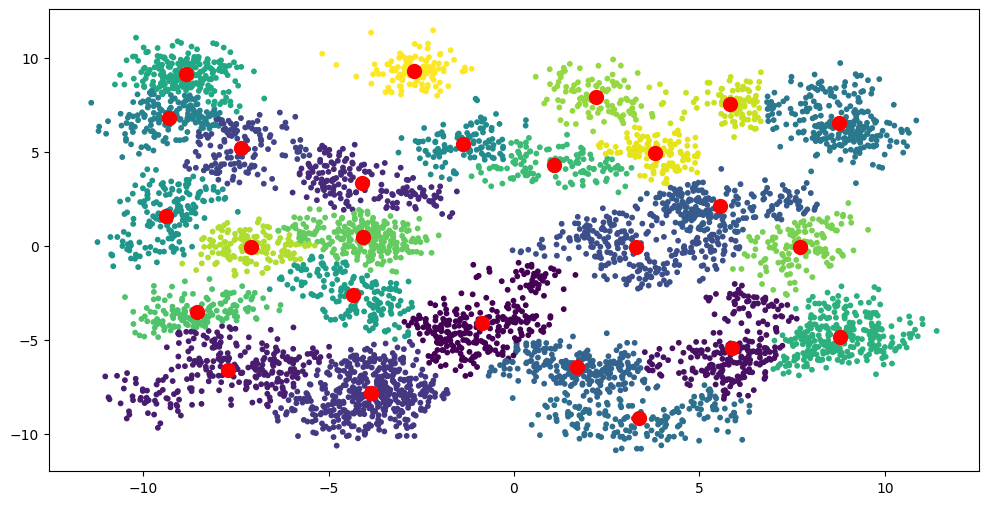

hom: 0.6533870539963236, comp: 0.9196126534741581, v: 0.7639709017333022


In [54]:
hc = AgglomerativeClustering(value)
y = hc.fit_predict(X)
plt.figure(figsize=(12,6))
plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="viridis")
plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], c='red', marker='o', s=100, label='Centroidi stimati')
plt.show()

hom, comp, v = scores(true_labels=true_lables, predicted_labels=y)

print(f'hom: {hom}, comp: {comp}, v: {v}')

ora proviamo l'algoritmo per diversi casi

In [55]:
results_df = pd.DataFrame(columns=["run", "hom", "comp", "v", "threshold", "n_clusters"])
for i in range(1,21):
  X, true_lables = generateRandomBlob(i)
  
  link_matrix = linkage(X, method="ward")
  #step=2
  threshold, value, _ = findBestThresholdWithClustersFast(link_matrix, X)
  
  centroids = estimate_centroids(X, link_matrix, threshold=threshold)

  hc = AgglomerativeClustering(value)
  y = hc.fit_predict(X)
  
  hom, comp, v = scores(true_labels=true_lables, predicted_labels=y)
  results_df.loc[len(results_df)] = [i, hom, comp, v, threshold, value]

  # print(f'hom: {hom}, comp: {comp}, v: {v}')
  
  # plt.figure(figsize=(12,6))
  # plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="viridis")
  # plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], c='red', marker='o', s=100, label='Centroidi stimati')
  # plt.show()

In [56]:
results_df

,run,hom,comp,v,threshold,n_clusters
0,1.0,0.626804,0.906467,0.741130,37.0,23.0
1,2.0,0.854304,0.973128,0.909853,11.0,43.0
2,3.0,0.614133,0.941193,0.743275,37.0,23.0
3,4.0,0.771625,0.979504,0.863225,15.0,45.0
4,5.0,0.627082,0.955405,0.757184,39.0,24.0
5,6.0,0.667713,0.974402,0.792418,25.0,39.0
6,7.0,0.730867,0.972353,0.834491,21.0,42.0
7,8.0,0.554918,0.886417,0.682546,39.0,20.0
8,9.0,0.587808,0.944978,0.724779,37.0,26.0
9,10.0,0.613930,0.912748,0.734095,21.0,37.0


In [57]:
results_df[['hom', 'comp', 'v']].mean()

hom     0.636166
comp    0.930699
v       0.753982
dtype: float64

In [20]:
less_precision_threshold = 0.9

In [21]:
results_df[results_df.hom<less_precision_threshold]

,run,hom,comp,v,threshold,n_clusters
0,1.0,0.626804,0.906467,0.741130,37.0,23.0
1,2.0,0.854304,0.973128,0.909853,11.0,43.0
2,3.0,0.614133,0.941193,0.743275,37.0,23.0
3,4.0,0.771625,0.979504,0.863225,15.0,45.0
4,5.0,0.627082,0.955405,0.757184,39.0,24.0
5,6.0,0.667713,0.974402,0.792418,25.0,39.0
6,7.0,0.730867,0.972353,0.834491,21.0,42.0
7,8.0,0.554918,0.886417,0.682546,39.0,20.0
8,9.0,0.587808,0.944978,0.724779,37.0,26.0
9,10.0,0.613930,0.912748,0.734095,21.0,37.0


In [22]:
results_df[results_df.comp<less_precision_threshold]

,run,hom,comp,v,threshold,n_clusters
7,8.0,0.554918,0.886417,0.682546,39.0,20.0
16,17.0,0.534153,0.886370,0.666595,35.0,25.0


In [23]:
results_df[results_df.v<less_precision_threshold]

,run,hom,comp,v,threshold,n_clusters
0,1.0,0.626804,0.906467,0.741130,37.0,23.0
2,3.0,0.614133,0.941193,0.743275,37.0,23.0
3,4.0,0.771625,0.979504,0.863225,15.0,45.0
4,5.0,0.627082,0.955405,0.757184,39.0,24.0
5,6.0,0.667713,0.974402,0.792418,25.0,39.0
6,7.0,0.730867,0.972353,0.834491,21.0,42.0
7,8.0,0.554918,0.886417,0.682546,39.0,20.0
8,9.0,0.587808,0.944978,0.724779,37.0,26.0
9,10.0,0.613930,0.912748,0.734095,21.0,37.0
10,11.0,0.583357,0.917477,0.713225,37.0,28.0
